In [729]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#EB984E', '#F4D03F', '#52BE80', '#5DADE2', '#AF7AC5', '#EC7063', '#45B39D', '#5499C7', '#F1948A', '#48C9B0', '#BB8FCE', '#76D7C4', '#D2B4DE', '#85C1E9', '#FAD02E', '#E59866', '#1ABC9C', '#F39C12', '#A569BD', '#3498DB', '#E74C3C', '#58D68D']
font1 = {'family':'serif','color':"darkred",'size':20}
font2 = {'family':'serif','color':'black','size':15}
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
import shap
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,make_scorer


In [730]:
def evaluate_model(model,X_test,y_true):
    y_pred = model.predict(X_test)
    print(classification_report(y_true,y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_regressor(model,X_test,y_true):
    y_pred = model.predict(X_test)
    m = mape(y_true,y_pred)
    print(f'MAPE : {m}')

mape_scorer = make_scorer(mape, greater_is_better=False)

In [731]:
def tune_model(model, param_grid, metric, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=metric, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

def tune_regressor(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mape_scorer, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [732]:
def IQR_method(df, n, features):
    outlier_indices = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outlier_indices_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_indices_column)
    
    outlier_counts = Counter(outlier_indices)
    multiple_outliers = [index for index, count in outlier_counts.items() if count > n]
    
    print('Total number of outliers is:', len(outlier_indices))
    
    return multiple_outliers

In [733]:
df = pd.read_csv('training_data.csv')

In [734]:
df.duplicated().value_counts()

False    51047
Name: count, dtype: int64

## Exploring the Data (EDA)

In [735]:
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [736]:
df.isnull().sum() ### the data has some NULL values

CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1    

In [737]:
df.dropna(inplace=True)

In [739]:
df.shape

(49752, 58)

In [740]:
categorical_feats = df.select_dtypes(include='object').columns
for feature in categorical_feats:
    print(f'\n************** {feature} **************\n')
    print(df[feature].value_counts())


************** Churn **************

Churn
No     35507
Yes    14245
Name: count, dtype: int64

************** ServiceArea **************

ServiceArea
NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: count, Length: 743, dtype: int64

************** ChildrenInHH **************

ChildrenInHH
No     37483
Yes    12269
Name: count, dtype: int64

************** HandsetRefurbished **************

HandsetRefurbished
No     42852
Yes     6900
Name: count, dtype: int64

************** HandsetWebCapable **************

HandsetWebCapable
Yes    44905
No      4847
Name: count, dtype: int64

************** TruckOwner **************

TruckOwner
No     40280
Yes     9472
Name: count, dtype: int64

************** RVOwner **************

RVOwner
No     45619
Yes     4133
Name: count, dtype: int64

************** Homeownership **************

Homeown

In [767]:
df_maj = df[df['MadeCallToRetentionTeam']=='No']
df_min = df[df['MadeCallToRetentionTeam']=='Yes']
df_min.shape

(1621, 58)

In [770]:
df_mix = pd.concat([df_maj.iloc[:1621],df_min])

In [759]:
df[df['MadeCallToRetentionTeam']=='No']['OptOutMailings'].value_counts()

OptOutMailings
No     47412
Yes      719
Name: count, dtype: int64

In [771]:
numerical_feats = df_mix.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_feats:
    print(f'\n************** {feature} **************\n')
    print(df_mix[feature].value_counts())


************** CustomerID **************

CustomerID
3000010    1
3089826    1
3087638    1
3087750    1
3087786    1
          ..
3009390    1
3009394    1
3009398    1
3009410    1
3399878    1
Name: count, Length: 3242, dtype: int64

************** MonthlyRevenue **************

MonthlyRevenue
29.99     47
30.00     29
34.99     27
30.26     26
16.99     24
          ..
118.74     1
56.27      1
102.35     1
21.36      1
19.96      1
Name: count, Length: 2479, dtype: int64

************** MonthlyMinutes **************

MonthlyMinutes
0.0       83
1.0       19
2.0       17
4.0       16
9.0       14
          ..
1113.0     1
1432.0     1
1707.0     1
275.0      1
821.0      1
Name: count, Length: 1320, dtype: int64

************** TotalRecurringCharge **************

TotalRecurringCharge
30.0     541
50.0     284
45.0     260
60.0     200
40.0     163
        ... 
138.0      1
180.0      1
103.0      1
338.0      1
208.0      1
Name: count, Length: 139, dtype: int64

************** D

In [772]:
categorical_feats = df_mix.select_dtypes(include='object').columns
for feature in categorical_feats:
    print(f'\n************** {feature} **************\n')
    print(df_mix[feature].value_counts())


************** Churn **************

Churn
No     2080
Yes    1162
Name: count, dtype: int64

************** ServiceArea **************

ServiceArea
DALDAL214    191
NYCBRO917    127
NYCMAN917    102
SANSAN210     90
PHXPHX602     88
            ... 
ATLTUN601      1
NYCKPT732      1
STLJEF573      1
NCRMID704      1
NEVELC619      1
Name: count, Length: 317, dtype: int64

************** ChildrenInHH **************

ChildrenInHH
No     2406
Yes     836
Name: count, dtype: int64

************** HandsetRefurbished **************

HandsetRefurbished
No     2508
Yes     734
Name: count, dtype: int64

************** HandsetWebCapable **************

HandsetWebCapable
Yes    2636
No      606
Name: count, dtype: int64

************** TruckOwner **************

TruckOwner
No     2498
Yes     744
Name: count, dtype: int64

************** RVOwner **************

RVOwner
No     2912
Yes     330
Name: count, dtype: int64

************** Homeownership **************

Homeownership
Known      2341


In [754]:
high_variance_features = []
for feature in numerical_feats[1:]:
    variance = df[feature].var()/df[feature].max()
    if variance > 1:
        print(f"Variance of {feature}: {variance}")
        high_variance_features.append(feature)

Variance of MonthlyRevenue: 1.6054031454589757
Variance of MonthlyMinutes: 37.95664953409495
Variance of TotalRecurringCharge: 1.4112836861633888
Variance of OverageMinutes: 2.1369119961818663
Variance of PercChangeMinutes: 12.608515950741143
Variance of UnansweredCalls: 1.7793483223517008
Variance of ReceivedCalls: 10.24795606691551
Variance of OutboundCalls: 1.9039124470484037
Variance of PeakCallsInOut: 5.2333457175924
Variance of OffPeakCallsInOut: 5.831679239641513
Variance of MonthsInService: 1.5550206153121688
Variance of CurrentEquipmentDays: 35.12708641557485
Variance of AgeHH1: 4.92968162462853
Variance of AgeHH2: 5.782643063776471
Variance of IncomeGroup: 1.075021972503951


In [748]:
df[df['AdjustmentsToCreditRating']==0]['Churn'].value_counts()

Churn
No     34168
Yes    13798
Name: count, dtype: int64

#### The HandSetPrice and the Marital Status Column have a lot of unknowns, which play a similar role as the NULL/NAN values, so they need to dealt with.

In [237]:
df['ServiceArea'] = df['ServiceArea'].apply(lambda x:x[:2])

In [238]:
len(df['ServiceArea'].value_counts())

41

C:\Users\maab9\AppData\Local\Temp\ipykernel_9024\3477696043.py:3: UserWarning: The palette list has more values (22) than needed (2), which may not be intended.
  sns.barplot(x=churn_counts.index,y=churn_counts.values,hue=churn_counts.index,palette=colors,edgecolor='black',linewidth=1.5)


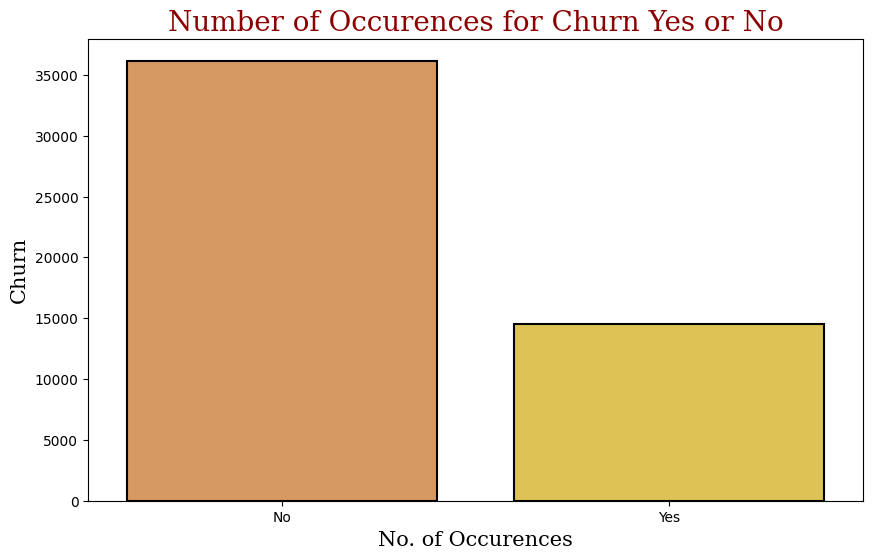

In [15]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=churn_counts.index,y=churn_counts.values,hue=churn_counts.index,palette=colors,edgecolor='black',linewidth=1.5)
plt.xlabel('No. of Occurences',fontdict=font2)
plt.ylabel('Churn',fontdict=font2)
plt.title('Number of Occurences for Churn Yes or No',fontdict=font1)
plt.show()

In [16]:
state_counts_df = df.groupby(['ServiceArea', 'Churn']).size().unstack(fill_value=0)
state_counts_df

Churn,No,Yes
ServiceArea,,
AI,461,184
AP,1786,620
AT,1306,520
AW,59,14
BI,84,30
BO,1056,483
CH,1401,607
DA,1734,651
DE,1606,677


In [17]:
state_counts_df['Total'] = state_counts_df.sum(axis=1)
percentage_df = state_counts_df[['Yes', 'No']].div(state_counts_df['Total'], axis=0) * 100
percentage_df = percentage_df.reset_index()
percentage_df.columns.name = None  

In [18]:
percentage_df

,ServiceArea,Yes,No
0,AI,28.527132,71.472868
1,AP,25.768911,74.231089
2,AT,28.477547,71.522453
3,AW,19.178082,80.821918
4,BI,26.315789,73.684211
5,BO,31.384016,68.615984
6,CH,30.229084,69.770916
7,DA,27.295597,72.704403
8,DE,29.653964,70.346036
9,FL,31.523458,68.476542


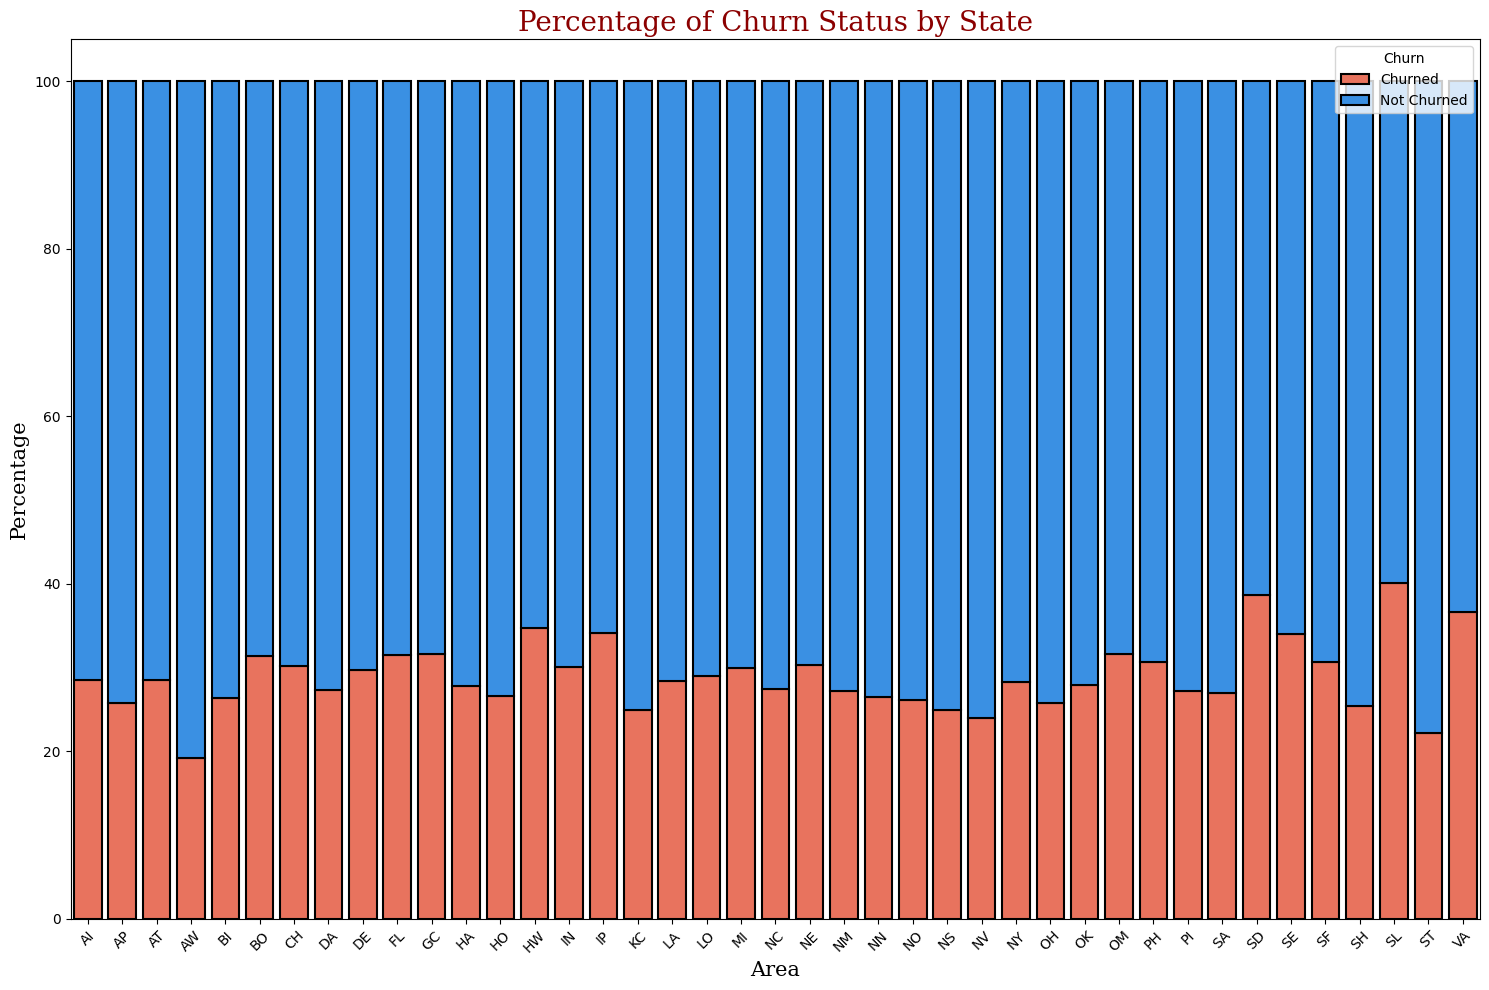

In [19]:
plt.figure(figsize=(15,10))

sns.barplot(x='ServiceArea', y='Yes', data=percentage_df, color='#FF6347',
            label='Churned', edgecolor='black', linewidth=1.5)

sns.barplot(x='ServiceArea', y='No', data=percentage_df, color='#1E90FF',
            bottom=percentage_df['Yes'], label='Not Churned',
            edgecolor='black', linewidth=1.5)

plt.xlabel('Area', fontdict=font2)
plt.ylabel('Percentage', fontdict=font2)
plt.title('Percentage of Churn Status by State', fontdict=font1)
plt.xticks(rotation=45)
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

In [20]:
# for feature in categorical_feats[2:] : 

#     counts_df = df.groupby([feature, 'Churn']).size().unstack(fill_value=0)
#     counts_df

#     counts_df['Total'] = counts_df.sum(axis=1)
#     percentage_df = counts_df[['Yes', 'No']].div(counts_df['Total'], axis=0) * 100
#     percentage_df = percentage_df.reset_index()
#     percentage_df.columns.name = None  
#     percentage_df

#     plt.figure(figsize=(15,10))

#     sns.barplot(x=feature, y='Yes', data=percentage_df, color='#FF6347',
#                 label='Churned', edgecolor='black', linewidth=1.5)

#     sns.barplot(x=feature, y='No', data=percentage_df, color='#1E90FF',
#                 bottom=percentage_df['Yes'], label='Not Churned',
#                 edgecolor='black', linewidth=1.5)

#     plt.xlabel(f'Feature', fontdict=font2)
#     plt.ylabel('Percentage', fontdict=font2)
#     plt.title(f'Percentage of Churn Status by {feature}', fontdict=font1)
#     plt.xticks(rotation=45)
#     plt.legend(title='Churn', loc='upper right')
#     plt.tight_layout()
#     plt.show()  

In [663]:
cols_to_drop_1 = ['CustomerID','MaritalStatus','NewCellphoneUser','NotNewCellphoneUser','HasCreditCard','OwnsComputer',
                  'NonUSTravel','OptOutMailings','BuysViaMailOrder','Homeownership','RVOwner','TruckOwner',
                  'ChildrenInHH']

In [664]:
df_1 = df.drop(cols_to_drop_1,axis=1)
df_1.shape

(50655, 57)

In [665]:
df_1.columns

Index(['Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'ServiceArea', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays',
       'AgeHH1', 'AgeHH2', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'RetentionCalls',
       'RetentionOffersAccepted', 'NewCellphoneUser', 'NotNewCellphoneUser',
       'ReferralsMadeBySubscriber', 'IncomeGroup', 'OwnsMoto

In [666]:
df_1['Churn'] = df_1['Churn'].apply(lambda x:1 if x=='Yes' else 0)

In [667]:
categorical_feats = df_1.select_dtypes(include='object').columns
for feature in categorical_feats:
    print(f'\n************** {feature} **************\n')
    print(df[feature].value_counts())


************** ServiceArea **************

ServiceArea
NY    5630
LA    3364
MI    3199
SF    2696
AP    2406
DA    2385
DE    2283
SA    2202
PH    2008
CH    2008
OH    1911
FL    1897
AT    1826
HO    1761
NC    1710
BO    1539
NE    1518
SE    1168
KC     999
HA     931
ST     924
NM     773
NN     701
AI     645
OK     601
IN     556
OM     500
LO     448
NO     422
NS     394
PI     323
HW     256
SL     167
SH     138
BI     114
AW      73
IP      44
VA      41
GC      38
SD      31
NV      25
Name: count, dtype: int64

************** ChildrenInHH **************

ChildrenInHH
No     38386
Yes    12269
Name: count, dtype: int64

************** HandsetRefurbished **************

HandsetRefurbished
No     43637
Yes     7018
Name: count, dtype: int64

************** HandsetWebCapable **************

HandsetWebCapable
Yes    45740
No      4915
Name: count, dtype: int64

************** TruckOwner **************

TruckOwner
No     41183
Yes     9472
Name: count, dtype: int64

********

In [26]:
numerical_feats = df.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_feats:
    print(f'\n************** {feature} **************\n')
    print(df[feature].value_counts())


************** CustomerID **************

CustomerID
3000002    1
3270658    1
3270682    1
3270686    1
3270698    1
          ..
3132850    1
3132858    1
3132862    1
3132870    1
3399974    1
Name: count, Length: 50655, dtype: int64

************** MonthlyRevenue **************

MonthlyRevenue
29.99     1065
34.99      801
10.00      465
30.00      403
49.99      392
          ... 
143.37       1
118.03       1
230.65       1
194.90       1
109.96       1
Name: count, Length: 12623, dtype: int64

************** MonthlyMinutes **************

MonthlyMinutes
0.0       687
2.0       130
8.0       125
6.0       122
88.0      116
         ... 
2422.0      1
2274.0      1
2020.0      1
2300.0      1
2437.0      1
Name: count, Length: 2718, dtype: int64

************** TotalRecurringCharge **************

TotalRecurringCharge
30.0     7266
45.0     6619
60.0     4427
40.0     4397
50.0     4137
         ... 
211.0       1
146.0       1
133.0       1
149.0       1
212.0       1
Name: coun

### It seems like these columns need some work :
#### AgeHH1, AgeHH2, contain a lot of 0 ages, which does not make sense
#### CallWaitingCalls,CallForwardingCalls,DroppedBlockedCalls,OffPeakCallsInout,PeakCallsInOutInboudCalls,OutboundCalls,ReceivedCalls, ThreewayCalls,CustomerCareCalls,UnansweredCalls,BlockedCalls,DroppedCalls,RoamingCalls,Director assisted calls as they should be integer values
#### Marital status , HandsetPrice have a lot of unknowns
#### HouseOwnership seems like a redundant column

# Preprocessing

In [677]:
categorical_feats

Index(['Churn', 'ServiceArea', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice',
       'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation',
       'MaritalStatus'],
      dtype='object')

In [569]:
df['ChildrenInHH']

0         No
1        Yes
2        Yes
3         No
4         No
        ... 
51037     No
51039     No
51040     No
51041     No
51043    Yes
Name: ChildrenInHH, Length: 50655, dtype: object

In [678]:
predictor_features = categorical_feats.delete([0,7,-1,-6])

In [672]:
for feature in predictor_features[:-3]:
    df_1[feature] = df_1[feature].apply (lambda x:1 if x=='Yes' else 0)

In [576]:
for feature in predictor_features[-3:]:
    print(df_1[feature].value_counts().index)

Index(['2-High', '1-Highest', '3-Good', '5-Low', '4-Medium', '7-Lowest',
       '6-VeryLow'],
      dtype='object', name='CreditRating')
Index(['Other', 'Suburban', 'Town', 'Rural'], dtype='object', name='PrizmCode')
Index(['Other', 'Professional', 'Crafts', 'Clerical', 'Self', 'Retired',
       'Student', 'Homemaker'],
      dtype='object', name='Occupation')


In [ ]:
['Town', 'Rural','Other', 'Suburban']

In [679]:
preprocessor=ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(categories='auto'), predictor_features)
],
                              remainder='passthrough'
)

In [673]:
preprocessor=ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(categories=[['7-Lowest','6-VeryLow','5-Low','4-Medium','3-Good','2-High', '1-Highest'],
                                           ['Town', 'Rural','Other', 'Suburban'],
                                            ['Student', 'Homemaker', 'Retired', 'Crafts', 'Clerical', 'Self', 'Professional', 'Other']
                                           ]
                                            ), predictor_features[-3:])
],
                              remainder='passthrough'
)

In [680]:
df_transformed = preprocessor.fit_transform(df_1)

In [681]:
all_features = preprocessor.get_feature_names_out()
actual_feature_names = [name.split('__')[-1] for name in all_features]
df_transformed = pd.DataFrame(df_transformed,columns=actual_feature_names)

In [682]:
df_transformed

,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,...,AgeHH1,AgeHH2,Homeownership,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,HandsetPrice,MaritalStatus
0,35.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,62.0,0.0,Known,1,0,0,4,0,30,No
1,32.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,40.0,42.0,Known,0,0,0,5,0,30,Yes
2,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,26.0,Unknown,0,0,0,6,0,Unknown,Yes
3,32.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,30.0,0.0,Known,0,0,0,6,0,10,No
4,29.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,46.0,54.0,Known,0,0,0,9,1,10,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50650,21.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,58.0,0.0,Known,0,0,0,3,0,Unknown,Yes
50651,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,Unknown,0,0,0,0,0,Unknown,Unknown
50652,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,50.0,60.0,Known,0,0,0,7,0,Unknown,Unknown
50653,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,0.0,Known,0,0,0,2,0,30,Yes


In [683]:
features_df = df_transformed.copy()

In [684]:
# features_df =features_df.drop(['Homeownership','Churn','MaritalStatus','HandsetPrice'],axis=1)

In [685]:
features_df['AgeHH1'] = features_df['AgeHH1'].apply(lambda x:np.nan if x==0.0 else x)
features_df['AgeHH2'] = features_df['AgeHH2'].apply(lambda x:np.nan if x==0.0 else x)

In [686]:
imputer = SimpleImputer(strategy='mean')
columns_to_impute = ['AgeHH1', 'AgeHH2']
features_df[columns_to_impute] = imputer.fit_transform(features_df[columns_to_impute])

In [687]:
int_cols = ['CallWaitingCalls', 'CallForwardingCalls', 'DroppedBlockedCalls',
                   'OffPeakCallsInOut', 'PeakCallsInOut', 'InboundCalls', 'OutboundCalls',
                   'ReceivedCalls', 'ThreewayCalls', 'CustomerCareCalls', 'UnansweredCalls',
                   'BlockedCalls', 'DroppedCalls', 'RoamingCalls', 'DirectorAssistedCalls','AgeHH1','AgeHH2']


features_df[int_cols] = features_df[int_cols].astype(int)


In [688]:
outlier_rows = IQR_method(features_df,5,numerical_feats[1:])

Total number of outliers is: 152574


In [689]:
features_df = features_df.drop(outlier_rows,axis=0)

In [690]:
features_df.shape

(42767, 57)

In [697]:
X_marital = features_df[features_df['MaritalStatus']!='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice'],axis=1).astype(float)
y_marital = features_df[features_df['MaritalStatus']!='Unknown']['MaritalStatus'].apply(lambda x:1 if x=='Yes' else 0)

In [698]:
X_train_marital,X_test_marital,y_train_marital,y_test_marital = train_test_split(X_marital,y_marital,test_size=0.2,random_state=1)

In [699]:
undersampler = RandomUnderSampler(sampling_strategy='auto',random_state=1)
X_train_marital,y_train_marital = undersampler.fit_resample(X_train_marital,y_train_marital)

In [700]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_marital,y_train_marital)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [701]:
evaluate_model(xgb,X_test_marital,y_test_marital)

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2102
           1       0.85      0.80      0.83      3242

    accuracy                           0.80      5344
   macro avg       0.79      0.79      0.79      5344
weighted avg       0.80      0.80      0.80      5344



In [429]:
n_estimators = [100, 300, 700, 1000]
subsample = [0.3,0.5,0.7,1.0]
max_depth = [2,4,10,20]
xgb_grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
xgb_model = tune_model(xgb,xgb_grid,'recall_macro',X_train_marital,y_train_marital)

In [430]:
evaluate_model(xgb_model,X_test_marital,y_test_marital)

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2102
           1       0.85      0.82      0.84      3242

    accuracy                           0.80      5344
   macro avg       0.80      0.80      0.80      5344
weighted avg       0.81      0.80      0.81      5344



In [702]:
marital_status = xgb.predict(features_df[features_df['MaritalStatus']=='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice'],axis=1).astype(float))
marital_status = np.array(marital_status).reshape(-1,1)
marital_status

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [703]:
features_df.loc[features_df[features_df['MaritalStatus']=='Unknown'].index,'MaritalStatus'] = marital_status

In [704]:
X_price = features_df[features_df['HandsetPrice']!='Unknown'].drop(['Churn','Homeownership','HandsetPrice','MaritalStatus'],axis=1).astype(float)   
y_price = features_df[features_df['HandsetPrice']!='Unknown']['HandsetPrice'].astype(int)          

In [705]:
X_train_price,X_test_price,y_train_price,y_test_price = train_test_split(X_price,y_price,test_size=0.2,random_state=1)

In [706]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train_price,y_train_price)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [601]:
xgb_regressor = tune_regressor(xgb,xgb_grid,X_train_price,y_train_price)

KeyboardInterrupt: 

In [707]:
evaluate_regressor(xgb,X_test_price,y_test_price)

MAPE : 101.51996464488298


In [708]:
price = xgb.predict(features_df[features_df['HandsetPrice']=='Unknown'].drop(['Churn','Homeownership','MaritalStatus','HandsetPrice'],axis=1).astype(float))
price = np.array(price).reshape(-1,1)
price = abs(price)
price.max()

268.17514

In [709]:
features_df.loc[features_df[features_df['HandsetPrice']=='Unknown'].index,'HandsetPrice'] = price

In [710]:
features_df['MaritalStatus'] = features_df['MaritalStatus'].replace('Yes',1)
features_df['MaritalStatus'] = features_df['MaritalStatus'].replace('No',0)

C:\Users\maab9\AppData\Local\Temp\ipykernel_9024\2521839984.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df['MaritalStatus'] = features_df['MaritalStatus'].replace('No',0)


In [711]:
X = features_df.drop(['Churn','Homeownership','ServiceArea'],axis=1).astype(float)
y = features_df['Churn'].astype(np.int64)

In [712]:
X.columns

Index(['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner',
       'RVOwner', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam',
       'CreditRating', 'PrizmCode', 'Occupation', 'MonthlyRevenue',
       'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls',
       'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes',
       'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls',
       'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls',
       'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut',
       'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls',
       'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets',
       'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
      

In [713]:
df['Occupation'].value_counts()

Occupation
Other           37356
Professional     8681
Crafts           1507
Clerical          979
Self              872
Retired           726
Student           377
Homemaker         157
Name: count, dtype: int64

In [714]:
features_df['Occupation'].value_counts()

Occupation
3.0    31033
4.0     7713
1.0     1297
0.0      855
6.0      760
5.0      658
7.0      312
2.0      139
Name: count, dtype: int64

In [715]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [716]:
X_train,X_test , y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=0)

In [717]:
y_train.value_counts()

Churn
0    24336
1     9877
Name: count, dtype: int64

In [718]:
X_train,y_train = undersampler.fit_resample(X_train,y_train)

In [719]:
rf_model = XGBClassifier()

In [720]:
rf_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [721]:
y_pred = rf_model.predict(X_test)

In [722]:
class_counts = np.bincount(y_pred)

# Print the counts for class 0 and class 1
count_0 = class_counts[0]
count_1 = class_counts[1]

print(f"Number of 0s in y_pred: {count_0}")
print(f"Number of 1s in y_pred: {count_1}")

Number of 0s in y_pred: 4658
Number of 1s in y_pred: 3896


In [723]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.61      0.70      6084
           1       0.40      0.63      0.49      2470

    accuracy                           0.62      8554
   macro avg       0.60      0.62      0.59      8554
weighted avg       0.68      0.62      0.63      8554



In [724]:
svc_model = SVC()

In [725]:
svc_model.fit(X_train,y_train)

SVC()

In [726]:
y_pred = svc_model.predict(X_test)

class_counts = np.bincount(y_pred)

# Print the counts for class 0 and class 1
count_0 = class_counts[0]
count_1 = class_counts[1]

print(f"Number of 0s in y_pred: {count_0}")
print(f"Number of 1s in y_pred: {count_1}")

Number of 0s in y_pred: 4496
Number of 1s in y_pred: 4058


In [727]:
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [728]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      6084
           1       0.36      0.60      0.45      2470

    accuracy                           0.58      8554
   macro avg       0.57      0.59      0.56      8554
weighted avg       0.66      0.58      0.60      8554



In [546]:
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train,y_train)

c:\Users\maab9\anaconda3\envs\churn\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

In [547]:
y_pred = lr_model.predict(X_test)

class_counts = np.bincount(y_pred)

# Print the counts for class 0 and class 1
count_0 = class_counts[0]
count_1 = class_counts[1]

print(f"Number of 0s in y_pred: {count_0}")
print(f"Number of 1s in y_pred: {count_1}")

Number of 0s in y_pred: 3951
Number of 1s in y_pred: 3674


In [548]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      4002
           1       0.73      0.74      0.73      3623

    accuracy                           0.74      7625
   macro avg       0.74      0.74      0.74      7625
weighted avg       0.74      0.74      0.74      7625



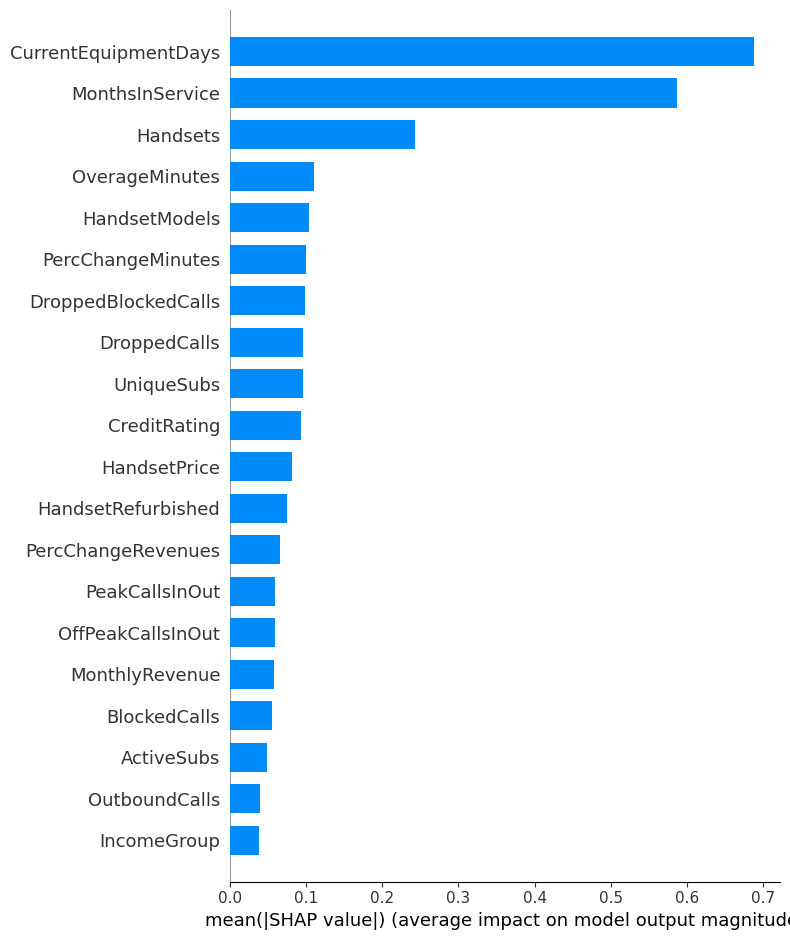

In [559]:
explainer_lr = shap.Explainer(lr_model,X_test)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar",feature_names=X_test.columns)
plt.show()

In [160]:
# y = df_transformed['AgeHH1']

# plt.figure(figsize=(8, 8))
# sns.boxplot(x='MaritalStatus', hue='MaritalStatus',y=y, data=df_transformed, palette=["#682F2F", "#F3AB60"], boxprops=dict(edgecolor='black', linewidth=1.5),legend=True)
# plt.xlabel('Churn',fontdict=font2)
# plt.ylabel(f'{feature}',fontdict=font2)
# plt.show()

KeyError: 'AgeHH1'